# Cat vs Dog Image Classifier Using Pretrained and Non-pretrained ResNet18 with PyTorch
### Author: Max Bluestone
### Date: 5/28/19

*This notebook was running on Google Colab to take advantage of the GPU*

## Train the convolutional neural network model

### Data Loading and Transformation

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# unzip img folder after uploading to google colab
!unzip img.zip

# load the data
data_dir = 'img'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [ ]:
# intialize data loaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Train Resnet18 from scratch

In [ ]:
# initialize resnet model (not pretrained)
model = models.resnet18(pretrained=False)

# change output to 2, binary class problem
model.fc = nn.Linear(model.fc.in_features, 2)

# run model on gpu if available
model = model.to(device)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters())

*Training function*

In [ ]:
# define function for training the model
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=50, verbose=True):
    """
    Function to train a neural network model on the cat-dog images
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        if (epoch+1) % 10 == 0 and verbose:
          print('Epoch {}/{}'.format(epoch+1, num_epochs))
          print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            #update loss arrays
            if phase == 'train':
                train_losses.append(epoch_loss)
            elif phase == 'val':
                val_losses.append(epoch_loss)

            if (epoch+1) % 10 == 0 and verbose:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    if verbose:
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, best_acc

*Train model with default hyperparameters*

Epoch 10/50
----------
train Loss: 0.7037 Acc: 0.5360

val Loss: 0.7011 Acc: 0.6500

Epoch 20/50
----------
train Loss: 0.6663 Acc: 0.5920

val Loss: 0.6811 Acc: 0.5500

Epoch 30/50
----------
train Loss: 0.6730 Acc: 0.5920

val Loss: 0.6732 Acc: 0.5900

Epoch 40/50
----------
train Loss: 0.6745 Acc: 0.5700

val Loss: 0.6825 Acc: 0.6000

Epoch 50/50
----------
train Loss: 0.6477 Acc: 0.6240

val Loss: 0.6960 Acc: 0.6000

Training complete in 3m 52s
Best val Acc: 0.660000


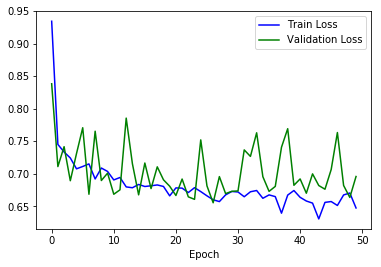

In [ ]:
# don't decay learning rate for now
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

# train model, only return losses for plotting
_, t_loss, v_loss,_ = train_model(model, loss_fn, optimizer, exp_lr_scheduler)

# plot losses
plt.plot(range(num_epochs),t_loss, '-b', label='Train Loss')
plt.plot(range(num_epochs),v_loss, '-g', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.show()

*Hyperparameter Tuning*

In [ ]:
import itertools

# Hyperparameters to tune
batch_sizes = [4,10,20]
learning_rate = [0.1,0.01,0.001]
learning_decay = [1,0.5,0.1]
weight_decay = [0,1e-7,1e-6]

# number of training epochs, only 30 for tuning
num_epochs = 30

# initialize scores and parameters lists
scores = []
params = []

# loop through tuning iterations
for bs, lr, ld, wd in itertools.product(batch_sizes, learning_rate, learning_decay, weight_decay):
  
    
    # record hyperparameter values
    params.append([bs, lr, ld, wd])
    
    # reload data with different batch size
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    # initialize new resnet model (not pretrained)
    tune_model = models.resnet18(pretrained=False)

    # change output to 2, binary class problem
    tune_model.fc = nn.Linear(model.fc.in_features, 2)

    # run model on gpu if available
    tune_model = tune_model.to(device)
    
    # define optimizer
    optimizer = torch.optim.Adam(tune_model.parameters(), lr=lr, weight_decay=wd)
    
    # Decay LR by some factor every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=ld)
    
    # train, only return best accuracy
    _, _, _, acc = train_model(tune_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=num_epochs, verbose=False)
    
    # record f1 score
    scores.append(acc)

# print best accuracy and the parameters of the model that achieved it
print("Best Score: {}".format(max(scores)))
print("\nBatch Size: ",params[scores.index(max(scores))][0],
     "\nLearning Rate: ",params[scores.index(max(scores))][1],
     "\nLearning Decay: ",params[scores.index(max(scores))][2],
     "\nWeight Decay: ",params[scores.index(max(scores))][3])

Best Score: 0.71

Batch Size:  4 
Learning Rate:  0.001 
Learning Decay:  1 
Weight Decay:  1e-06


It makes sense that a scheduled learning decay wouldn't matter because Adam has it's own adaptive learning rate.

In [ ]:
# retrain model with tuned hyperparameters
batch_size = 4
learning_rate = 0.001
learning_decay = 1
weight_decay = 1e-6

# reload data with different batch size
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# initialize new resnet model (not pretrained)
tuned_model = models.resnet18(pretrained=False)

# change output to 2, binary class problem
tuned_model.fc = nn.Linear(tuned_model.fc.in_features, 2)

# run model on gpu if available
tuned_model = tuned_model.to(device)

# define optimizer
optimizer = torch.optim.Adam(tuned_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Decay LR by some factor every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=learning_decay)

# train, only return model
tuned_model, _, _, _ = train_model(tuned_model, loss_fn, optimizer, exp_lr_scheduler, verbose=False)

*Make predictions on validation set*

In [ ]:
# evaluation mode
was_training = tuned_model.training
tuned_model.eval()

# initialize label and prediction arrays
all_lbls = np.array([])
all_preds = np.array([])

# don't update gradients
with torch.no_grad():
    # loop through image batches
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # make predicitions
        outputs = tuned_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # add batch labels and preds to full arrays
        all_lbls = np.append(all_lbls,labels.cpu().numpy())
        all_preds = np.append(all_preds,preds.cpu().numpy())

    tuned_model.train(mode=was_training)

In [ ]:
# create a function for calculating and outputing evaluation metrics for the validation set
import pandas as pd
from sklearn.metrics import confusion_matrix
def metrics(ground_truth, predictions):
    '''
    Function to calculate and return evaluation metrics for classification
    '''
    # contingency table
    ct_data = pd.DataFrame([ground_truth,predictions]).T
    ct_data.columns=["Ground Truth","Predicted"]
    ct_data[ct_data==0]="cat"
    ct_data[ct_data==1]="dog"
    ct = pd.crosstab(ct_data["Predicted"],ct_data["Ground Truth"],margins=False)
    
    # metrics
    cm = confusion_matrix(ground_truth, predictions)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    print("\nContigency Table:\n",ct,
          "\n\nAccuracy: {:.4f}".format(accuracy),
          "\nPrecision: {:.4f}".format(precision),
          "\nRecall: {:.4f}".format(recall),
          "\nF1 Score: {:.4f}".format(f1_score))

# print out metrics
metrics(all_lbls, all_preds)


Contigency Table:
 Ground Truth  cat  dog
Predicted             
cat            31   14
dog            19   36 

Accuracy: 0.6700 
Precision: 0.6545 
Recall: 0.7200 
F1 Score: 0.6857


Not so great...

### Transfer learning: pre-trained Resnet18 on ImageNet

In [ ]:
# initialize resnet model (pretrained)
pt_model = models.resnet18(pretrained=True)
for param in pt_model.parameters():
    param.requires_grad = False

# change output to 2, binary class problem
pt_model.fc = nn.Linear(pt_model.fc.in_features, 2)

# run model on gpu if available
pt_model = pt_model.to(device)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer, only for last layer
optimizer = optim.Adam(pt_model.fc.parameters())

*Train model with default hyperparameters*

Epoch 10/20
----------
train Loss: 0.3906 Acc: 0.8400

val Loss: 0.0599 Acc: 0.9700

Epoch 20/20
----------
train Loss: 0.3778 Acc: 0.8200

val Loss: 0.0566 Acc: 0.9800

Training complete in 1m 28s
Best val Acc: 0.990000


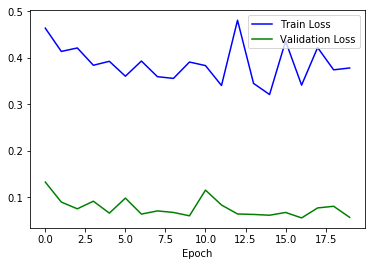

In [ ]:
# don't decay learning rate for now
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

# train model, only return losses for plotting
num_epochs=20
_, t_loss, v_loss,_ = train_model(pt_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

# plot losses
plt.plot(range(num_epochs),t_loss, '-b', label='Train Loss')
plt.plot(range(num_epochs),v_loss, '-g', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.show()

*Hyperparameter Tuning*

In [ ]:
# Hyperparameters to tune
batch_sizes = [4,10]
learning_rate = [0.1,0.01,0.001]
learning_decay = [1,0.5,0.1]
weight_decay = [0,1e-7,1e-6]

# number of training epochs, only 30 for tuning
num_epochs = 20

# initialize scores and parameters lists
scores = []
params = []

# loop through tuning iterations
for bs, lr, ld, wd in itertools.product(batch_sizes, learning_rate, learning_decay, weight_decay):
    
    # record hyperparameter values
    params.append([bs, lr, ld, wd])
    
    # reload data with different batch size
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    # initialize resnet model (pretrained)
    tune_pt_model = models.resnet18(pretrained=True)
    for param in tune_pt_model.parameters():
        param.requires_grad = False

    # change output to 2, binary class problem
    tune_pt_model.fc = nn.Linear(tune_pt_model.fc.in_features, 2)

    # run model on gpu if available
    tune_pt_model = tune_pt_model.to(device)

    # define loss function
    loss_fn = nn.CrossEntropyLoss()

    # define optimizer, only for last layer
    optimizer = optim.Adam(tune_pt_model.fc.parameters(), lr=lr, weight_decay=wd)
    
    # Decay LR by some factor every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=ld)
    
    # train, only return best accuracy
    _, _, _, acc = train_model(tune_pt_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=num_epochs, verbose=False)
    
    # record f1 score
    scores.append(acc)

# print best accuracy and the parameters of the model that achieved it
print("Best Score: {}".format(max(scores)))
print("\nBatch Size: ",params[scores.index(max(scores))][0],
     "\nLearning Rate: ",params[scores.index(max(scores))][1],
     "\nLearning Decay: ",params[scores.index(max(scores))][2],
     "\nWeight Decay: ",params[scores.index(max(scores))][3])

Best Score: 1.0

Batch Size:  4 
Learning Rate:  0.01 
Learning Decay:  1 
Weight Decay:  1e-06


*Retrain Model with Tuned Hyperparameters and Evaluate on Validation Set*

In [ ]:
# retrain model with tuned hyperparameters
batch_size = 4
learning_rate = 0.01
learning_decay = 1
weight_decay = 1e-6

# reload data with different batch size
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# initialize resnet model (pretrained)
tuned_pt_model = models.resnet18(pretrained=True)
for param in tuned_pt_model.parameters():
    param.requires_grad = False

# change output to 2, binary class problem
tuned_pt_model.fc = nn.Linear(tuned_pt_model.fc.in_features, 2)

# run model on gpu if available
tuned_pt_model = tuned_pt_model.to(device)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer, only for last layer
optimizer = optim.Adam(tuned_pt_model.fc.parameters(), lr=lr, weight_decay=wd)

# Decay LR by some factor every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=learning_decay)

# train, only return model
tuned_pt_model, _, _, _ = train_model(tuned_pt_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=20, verbose=False)

# evaluation mode
was_training = tuned_pt_model.training
tuned_pt_model.eval()

# initialize label and prediction arrays
all_lbls = np.array([])
all_preds = np.array([])

# don't update gradients
with torch.no_grad():
    # loop through image batches
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # make predicitions
        outputs = tuned_pt_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # add batch labels and preds to full arrays
        all_lbls = np.append(all_lbls,labels.cpu().numpy())
        all_preds = np.append(all_preds,preds.cpu().numpy())

    tuned_pt_model.train(mode=was_training)
    
# print out metrics
metrics(all_lbls, all_preds)


Contigency Table:
 Ground Truth  cat  dog
Predicted             
cat            48    0
dog             2   50 

Accuracy: 0.9800 
Precision: 0.9615 
Recall: 1.0000 
F1 Score: 0.9804


The training on the pre-trained model is different from the non pre-trained model in that training the pre-trained model for our classification problem only updates the parameters of the final fully connected layer of the neural network to give us our binary output of 'cat' or 'dog'. Training the non pre-trained model, on the other hand, updates the weights for every layer of the neural network during training. Because the pre-trained model has been exhaustively trained on tons of images, it performs much better at our simple 'cat' vs 'dog' classification task.